In [ ]:
# Importing Required Packages
!pip install wfdb
import pandas as pd
import numpy as np
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
from keras.layers import Conv1D
import wfdb                            # Package for loading the ecg and annotation
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore") 
import random
from keras.layers import Bidirectional, LSTM
# Random Initialization
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 14.0 MB/s 
     |████████████████████████████████| 11.2 MB 37.3 MB/s 
     |████████████████████████████████| 930 kB 47.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 11.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Importing Data
import os
from google.colab import drive
import glob
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/mit/'
os.chdir('/content/drive/MyDrive/mit')

In [ ]:
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

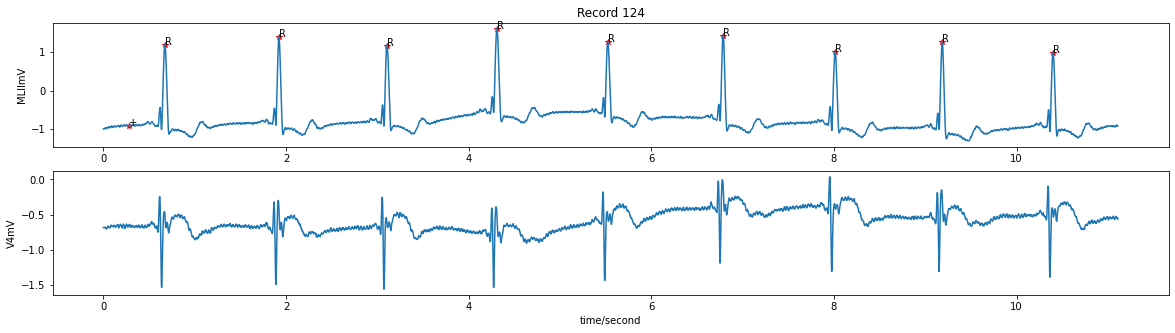

In [ ]:
import wfdb
sampfrom = 0
sampto = 4000
record = wfdb.rdrecord("124", sampfrom=sampfrom, sampto=sampto)    # record = (signals, fields)
annotations = wfdb.rdann("124", "atr", sampfrom=sampfrom, sampto=sampto)
wfdb.plot_wfdb(record=record, annotation=annotations, plot_sym=True,
               figsize=(20, 5), time_units="seconds", title='Record 124')

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Analysing Data</font></h4>
    </strong>
</div>

In [ ]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

In [ ]:
# Symbols Dataframe
symbols_df

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


In [ ]:

# Value Counts of Different symbols in data
value = symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)
value

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

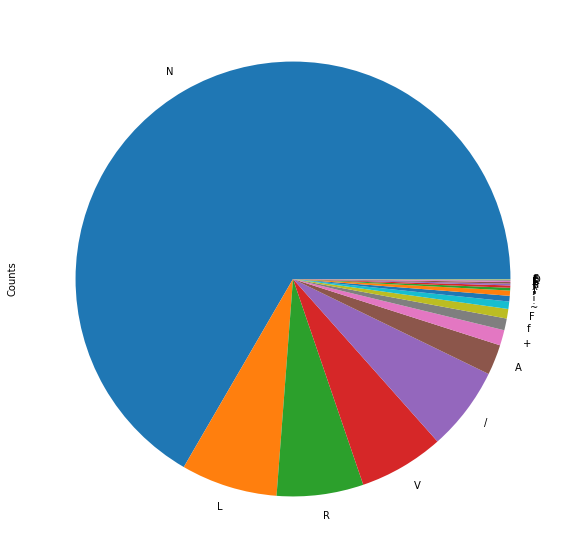

In [ ]:
value.plot(kind='pie',figsize=(25,10))
plt.show()

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Transformation</font></h4>
    </strong>
</div>

In [ ]:


# ventricular Beat Symbols
Ventricular = ['[',']','V','!','F','E']

# Non ventricular Beat Symbols
Non_Ventricular = ['N','x','|','x','S','e','Q','J','a','j','"','!','~','A','+','f','/','R','L']

In [ ]:
# Classifying ventricular beats, non ventricular beats
symbols_df.loc[symbols_df.symbol.isin(Non_Ventricular),'category'] = 0
symbols_df.loc[symbols_df.symbol.isin(Ventricular), 'category'] = 1

In [ ]:
# Value counts of different categories
values = symbols_df.groupby('category').Counts.sum()
values

category
0.0    104124
1.0      8523
Name: Counts, dtype: int64

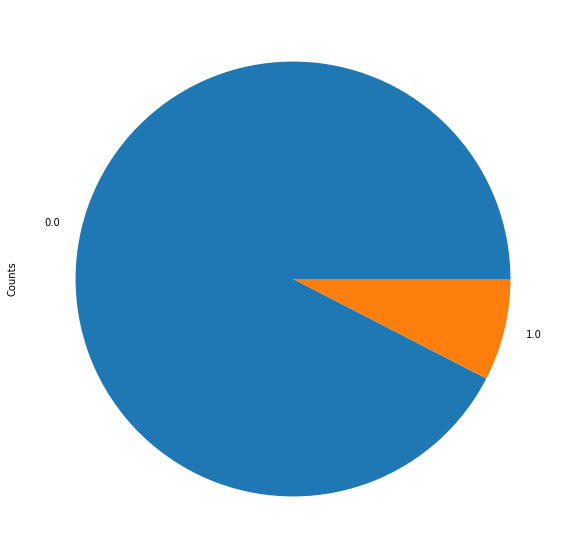

In [ ]:
values.plot(kind='pie',figsize=(25,10))
plt.show()

In [ ]:
def load_ecg(file):    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [ ]:
# Accessing the ecg points for 
file = data + patients[9]

In [ ]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Visualization</font></h4>
    </strong>
</div>

In [ ]:
# get ventricular beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in Ventricular]
ab_index

[6259,
 11310,
 13924,
 27656,
 33243,
 45777,
 84823,
 104538,
 153073,
 154320,
 176053,
 183625,
 190399,
 216588,
 219757,
 234817,
 245497,
 304544,
 330238,
 335577,
 370975,
 374076,
 381279,
 391914,
 394504,
 398397,
 407958,
 411350,
 420372,
 474074,
 511144,
 524267,
 545162,
 580349,
 583668,
 596173,
 603548,
 608075,
 631628,
 648784]

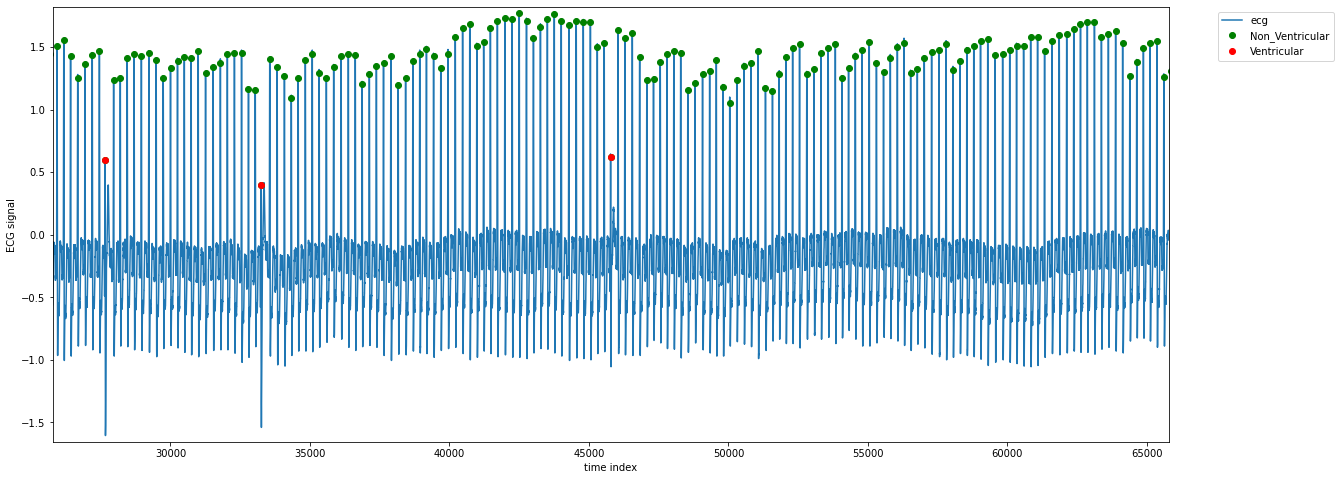

In [ ]:
# Generating evenly spaced values
x = np.arange(len(p_signal))

left = ab_index[5]-20000
right = ab_index[5]+20000

plt.figure(figsize=(20,8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='Non_Ventricular')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='Ventricular')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Preprocessing</font></h4>
    </strong>
</div>

In [ ]:
def make_dataset(pts, num_sec, fs, Ventricular):
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
       
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(Ventricular + Non_Ventricular)]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, Ventricular)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all


In [ ]:
def build_XY(p_signal, df_ann, num_cols, Ventricular,):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1,))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in Ventricular)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [ ]:
# Parameter Values
num_sec = 3
fs = 360

In [ ]:
# Accessing the fuction and creating a dataset with ECG digital Points
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, Ventricular)

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Training Models</font></h4>
    </strong>
</div>

<div style="background:#5990f7;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Dense Neural Networks(DNN)</font></h4>
    </strong>
</div>

In [ ]:
# Relu for activation function and drop out for regularization
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# Compiling model with  binary crossentropy and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
# Fitting the model
a=model.fit(X_train, y_train, batch_size = 32, epochs= 10, verbose = 1)

Epoch 1/10
2350/2350 [==============================] - 6s 3ms/step - loss: 0.0486 - accuracy: 0.9862
Epoch 2/10
2350/2350 [==============================] - 6s 2ms/step - loss: 0.0490 - accuracy: 0.9859
Epoch 3/10
2350/2350 [==============================] - 6s 2ms/step - loss: 0.0467 - accuracy: 0.9856
Epoch 4/10
2350/2350 [==============================] - 6s 2ms/step - loss: 0.0460 - accuracy: 0.9865
Epoch 5/10
2350/2350 [==============================] - 6s 2ms/step - loss: 0.0452 - accuracy: 0.9865
Epoch 6/10
2350/2350 [==============================] - 6s 3ms/step - loss: 0.0431 - accuracy: 0.9871
Epoch 7/10
2350/2350 [==============================] - 6s 3ms/step - loss: 0.0410 - accuracy: 0.9879
Epoch 8/10
2350/2350 [==============================] - 6s 2ms/step - loss: 0.0434 - accuracy: 0.9876
Epoch 9/10
2350/2350 [==============================] - 6s 2ms/step - loss: 0.0423 - accuracy: 0.9878
Epoch 10/10
2350/2350 [==============================] - 6s 3ms/step - loss: 0.039

In [ ]:
a.a.keys()

AttributeError: ignored

In [ ]:
epoch = range(1,epochs+1)
plt.plot(epoch, loss_train, 'g', label='Training accuracy')
plt.plot(epoch, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# Evaluation Metrics
def print_report(y_actual, y_pred, thresh):
    # Function to print evaluation metrics
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
    prevalence = (sum(y_actual)/len(y_actual))
    print('AUC:%.3f'%auc)
    print('Accuracy:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precision:%.3f'%precision)
    print('Specificity:%.3f'%specificity)
    print('Prevalence:%.3f'%prevalence)
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [ ]:
# Predictions
y_train_preds_dense = model.predict(X_train,verbose = 1)
y_test_preds_dense = model.predict(X_test,verbose = 1)

1158/1158 [==============================] - 2s 2ms/step


In [ ]:
# Threshold Value
thresh = (sum(y_train)/len(y_train))[0]

In [ ]:
# Accessing Evaluation Metrics Function
print('On Train Data')
print_report(y_train, y_train_preds_dense, thresh)
print('On Test Data')
print_report(y_test, y_test_preds_dense, thresh)

On Train Data
AUC:0.991
Accuracy:0.974
Recall:0.955
Precision:0.759
Specificity:0.975
Prevalence:0.075
 
On Test Data
AUC:0.984
Accuracy:0.969
Recall:0.935
Precision:0.731
Specificity:0.971
Prevalence:0.077
 


(0.9837656696159331,
 0.9685179685179686,
 0.9346451159522137,
 0.7307692307692307,
 array([0.97133749]))

<div style="background:#5990f7;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Convolutional Neural Networks(CNN)</font></h4>
    </strong>
</div>

In [ ]:
# reshape input to [samples, time steps, features = 1] for CNN
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train_cnn.shape)
print(X_test_cnn.shape)

(75196, 2160, 1)
(37037, 2160, 1)


In [ ]:
# Relu for activation function & Dropout for reducing overfitting by randomly removing some nodes.
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model with binary crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


In [ ]:
# Fitting data in model
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
1273/2350 [===============>..............] - ETA: 3:21 - loss: 0.1105 - accuracy: 0.9671

KeyboardInterrupt: ignored

In [ ]:
# Predictions
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)
y_test_preds_cnn = model.predict(X_test_cnn,verbose = 1)

860/860 [==============================] - 32s 38ms/step


In [ ]:
# Metrics
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Test');
print_report(y_test, y_test_preds_cnn, thresh);

Train
AUC:0.993
Accuracy:0.966
Recall:0.970
Precision:0.759
Specificity:0.965
Prevalence:0.101
 
Valid
AUC:0.990
Accuracy:0.963
Recall:0.956
Precision:0.753
Specificity:0.964
Prevalence:0.104
 


<div style="background:#5990f7;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Long Short Term Memory (LSTM)</font></h4>
    </strong>
</div>

In [ ]:
# Bidirectional LSTM with Dropout for reducing overfitting by randomly removing some nodes.
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
# Fitting Data
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 1, verbose = 1)

 623/1745 [=========>....................] - ETA: 32:48 - loss: 0.3331 - accuracy: 0.8952

KeyboardInterrupt: ignored

In [ ]:
# Prediction
y_train_preds_lstm = model.predict(X_train_cnn[:10000],verbose = 1)
y_test_preds_lstm = model.predict(X_test_cnn,verbose = 1)

860/860 [==============================] - 247s 287ms/step


In [ ]:
# Metrics
print('Train');
print_report(y_train[:10000], y_train_preds_lstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm, thresh);

Train
AUC:0.602
Accuracy:0.395
Recall:0.747
Precision:0.112
Specificity:0.357
Prevalence:0.098
 
Valid
AUC:0.595
Accuracy:0.396
Recall:0.741
Precision:0.118
Specificity:0.356
Prevalence:0.104
 


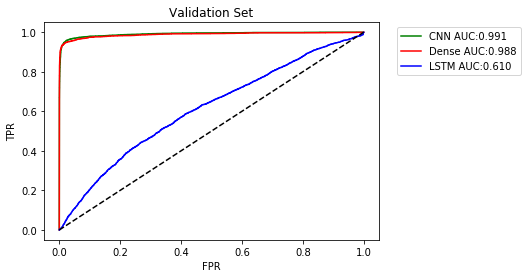

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_valid, y_valid_preds_dense)
auc_valid_dense = roc_auc_score(y_valid, y_valid_preds_dense)

fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_valid_dense, tpr_valid_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)
plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()
